In [105]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score, make_scorer
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
import lightgbm as lgb
from haversine import haversine
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
import joblib
import folium
from folium.plugins import HeatMap
import requests

In [106]:
data = pd.read_csv("train.csv")

In [107]:
data.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,26:21.0,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,52:16.0,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,35:00.0,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,30:42.0,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,51:00.0,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [108]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   key                50000 non-null  object 
 1   fare_amount        50000 non-null  float64
 2   pickup_datetime    50000 non-null  object 
 3   pickup_longitude   50000 non-null  float64
 4   pickup_latitude    50000 non-null  float64
 5   dropoff_longitude  50000 non-null  float64
 6   dropoff_latitude   50000 non-null  float64
 7   passenger_count    50000 non-null  int64  
dtypes: float64(5), int64(1), object(2)
memory usage: 3.1+ MB


In [109]:
data.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,11.364171,-72.509756,39.933759,-72.504616,39.926251,1.667840
std,9.685557,10.393860,6.224857,10.407570,6.014737,1.289195
min,-5.000000,-75.423848,-74.006893,-84.654241,-74.006377,0.000000
25%,6.000000,-73.992062,40.734880,-73.991152,40.734372,1.000000
50%,8.500000,-73.981840,40.752678,-73.980082,40.753372,1.000000
75%,12.500000,-73.967148,40.767360,-73.963584,40.768167,2.000000
max,200.000000,40.783472,401.083332,40.851027,43.415190,6.000000


In [110]:
data.drop('key', axis=1, inplace=True)
data.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [111]:
print("Missing values per column:")
print(data.isnull().sum())

Missing values per column:
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64


In [112]:
data = data[(data['fare_amount'] > 0) & (data['fare_amount'] < 250)]

data = data[(data['passenger_count'] > 0) & (data['passenger_count'] <= 6)]

NYC_LAT_MIN, NYC_LAT_MAX = 40.477399, 40.917577
NYC_LON_MIN, NYC_LON_MAX = -74.259090, -73.700272

data = data[
    (data['pickup_latitude'] >= NYC_LAT_MIN) & (data['pickup_latitude'] <= NYC_LAT_MAX) &
    (data['pickup_longitude'] >= NYC_LON_MIN) & (data['pickup_longitude'] <= NYC_LON_MAX) &
    (data['dropoff_latitude'] >= NYC_LAT_MIN) & (data['dropoff_latitude'] <= NYC_LAT_MAX) &
    (data['dropoff_longitude'] >= NYC_LON_MIN) & (data['dropoff_longitude'] <= NYC_LON_MAX)
]

print(f"Dataset size after cleaning: {data.shape}")


Dataset size after cleaning: (48706, 7)


In [113]:
data.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,48706.000000,48706.000000,48706.000000,48706.000000,48706.000000,48706.000000
mean,11.315764,-73.975569,40.750871,-73.974377,40.751362,1.674989
std,9.387540,0.034243,0.026922,0.034107,0.030702,1.289228
min,0.010000,-74.248263,40.522263,-74.241953,40.484335,1.000000
25%,6.000000,-73.992317,40.736522,-73.991337,40.735929,1.000000
50%,8.500000,-73.982133,40.753421,-73.980511,40.754098,1.000000
75%,12.500000,-73.968445,40.767720,-73.965447,40.768436,2.000000
max,165.000000,-73.702795,40.891938,-73.701188,40.911983,6.000000


In [114]:
data['pickup_datetime'] = pd.to_datetime(data['pickup_datetime'])

data['pickup_hour'] = data['pickup_datetime'].dt.hour
data['pickup_weekday'] = data['pickup_datetime'].dt.weekday
data['pickup_month'] = data['pickup_datetime'].dt.month


In [115]:
def calculate_haversine_distance(row):
    pickup = (row['pickup_latitude'], row['pickup_longitude'])
    dropoff = (row['dropoff_latitude'], row['dropoff_longitude'])
    return haversine(pickup, dropoff)

data['haversine_distance_km'] = data.apply(calculate_haversine_distance, axis=1)
data = data[data['haversine_distance_km'] != 0]

data.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_hour,pickup_weekday,pickup_month,haversine_distance_km
0,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1,17,0,6,1.030765
1,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1,16,1,1,8.450145
2,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2,0,3,8,1.389527
3,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1,4,5,4,2.799274
4,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1,7,1,3,1.999160


In [116]:
data['is_night'] = ((data['pickup_hour'] >= 20) & (data['pickup_hour'] <= 23)).astype(int)
data['is_late_night'] = ((data['pickup_hour'] > 23) | (data['pickup_hour'] <= 6)).astype(int)
data['is_weekend'] = (data['pickup_weekday'] >=5).astype(int)

In [117]:
data.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_hour,pickup_weekday,pickup_month,haversine_distance_km,is_night,is_late_night,is_weekend
0,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1,17,0,6,1.030765,0,0,0
1,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1,16,1,1,8.450145,0,0,0
2,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2,0,3,8,1.389527,0,1,0
3,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1,4,5,4,2.799274,0,1,1
4,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1,7,1,3,1.999160,0,0,0


In [118]:
#normalization
scaler = MinMaxScaler()

scaler.fit(data[['fare_amount', 'haversine_distance_km']]) 

data[['fare_amount', 'haversine_distance_km']] = scaler.transform(data[['fare_amount', 'haversine_distance_km']])
data.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_hour,pickup_weekday,pickup_month,haversine_distance_km,is_night,is_late_night,is_weekend
0,0.027214,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1,17,0,6,0.030454,0,0,0
1,0.102370,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1,16,1,1,0.249674,0,0,0
2,0.034487,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2,0,3,8,0.041054,0,1,0
3,0.046609,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1,4,5,4,0.082708,0,1,1
4,0.032063,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1,7,1,3,0.059067,0,0,0


In [119]:
# Latitude and longitude differences
data['lat_diff'] = data['dropoff_latitude'] - data['pickup_latitude']
data['lon_diff'] = data['dropoff_longitude'] - data['pickup_longitude']

In [120]:
data.head(5)

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_hour,pickup_weekday,pickup_month,haversine_distance_km,is_night,is_late_night,is_weekend,lat_diff,lon_diff
0,0.027214,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1,17,0,6,0.030454,0,0,0,-0.009041,0.002701
1,0.102370,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1,16,1,1,0.249674,0,0,0,0.070701,0.036780
2,0.034487,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2,0,3,8,0.041054,0,1,0,-0.010708,-0.008504
3,0.046609,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1,4,5,4,0.082708,0,1,1,0.024949,-0.004437
4,0.032063,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1,7,1,3,0.059067,0,0,0,0.015754,0.011440


# NOTE :

The cell below consist of code to find the haversine distance from pickup location to dropoff location. For this we have connected this notebook with  docker to get the accurate distance. Below cell will result in error if you don't have docker setup and connected with the notebook. For the convineance sake  we have calculated the distances and created a seperate dataset to store all the calculate records in **"data_with_distance.csv"**. You can directly use that dataset for reproducing further results. Additionally the code for calculating distance in docker is present in the **README.MD** file.


In [ ]:
def get_route(start_lat, start_lon, end_lat, end_lon):
    if None in [start_lat, start_lon, end_lat, end_lon]:
        print("Error: Missing coordinates")
        return None, None  

    url = f"http://localhost:5000/route/v1/driving/{start_lon},{start_lat};{end_lon},{end_lat}?overview=false"
    
    try:
        response = requests.get(url)
        response.raise_for_status()  
    except requests.exceptions.RequestException as e:
        print(f"Request failed: {e}")
        return None, None  

    if response.status_code == 200:
        data = response.json()
        distance = data['routes'][0]['distance'] / 1000  
        duration = data['routes'][0]['duration'] / 60  
        return distance, duration  
    else:
        print(f"Error: Unable to fetch route, Status Code: {response.status_code}")
        return None, None  

data[['osrm_distance', 'osrm_duration']] = data.apply(
    lambda row: pd.Series(get_route(
        row['pickup_latitude'], row['pickup_longitude'],
        row['dropoff_latitude'], row['dropoff_longitude']
    )),
    axis=1
)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48188 entries, 0 to 49998
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   fare_amount            48188 non-null  float64            
 1   pickup_datetime        48188 non-null  datetime64[ns, UTC]
 2   pickup_longitude       48188 non-null  float64            
 3   pickup_latitude        48188 non-null  float64            
 4   dropoff_longitude      48188 non-null  float64            
 5   dropoff_latitude       48188 non-null  float64            
 6   passenger_count        48188 non-null  int64              
 7   pickup_hour            48188 non-null  int32              
 8   pickup_weekday         48188 non-null  int32              
 9   pickup_month           48188 non-null  int32              
 10  haversine_distance_km  48188 non-null  float64            
 11  is_night               48188 non-null  int64              


In [ ]:
data = data.dropna()

In [ ]:
data.to_csv('data_with_distance.csv', index=False)

#FOR DIRECTLY USING DATASET WITHOUT DOCKER :
#data = pd.read_csv("data_with_distance.csv")

In [ ]:
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in kilometers
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    delta_phi = np.radians(lat2 - lat1)
    delta_lambda = np.radians(lon2 - lon1)
    a = np.sin(delta_phi / 2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2)**2
    return 2 * R * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

In [ ]:
hotspots = {
    "JFK": (40.6413, -73.7781),
    "EWR": (40.6895, -74.1745),
    "LGA": (40.7769, -73.8740),
    "Downtown": (40.7128, -74.0060)
}

proximity_threshold_km = 1

for name, coords in hotspots.items():
    data[f'pickup_near_{name}'] = haversine(
        data['pickup_latitude'], data['pickup_longitude'], coords[0], coords[1]
    ) <= proximity_threshold_km
    
    data[f'dropoff_near_{name}'] = haversine(
        data['dropoff_latitude'], data['dropoff_longitude'], coords[0], coords[1]
    ) <= proximity_threshold_km

data['near_hotspot'] = (
    data[[f'pickup_near_{name}' for name in hotspots]] |
    data[[f'dropoff_near_{name}' for name in hotspots]]
).any(axis=1).astype(int)

drop_columns = [f'pickup_near_{name}' for name in hotspots] + [f'dropoff_near_{name}' for name in hotspots]
data.drop(columns=drop_columns, inplace=True)

data.head()


,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_hour,pickup_weekday,pickup_month,haversine_distance_km,is_night,is_late_night,is_weekend,lat_diff,lon_diff,osrm_distance,osrm_duration,near_hotspot
0,0.027214,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1,17,0,6,0.030454,0,0,0,-0.009041,0.002701,1.2451,3.196667,0
1,0.102370,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1,16,1,1,0.249674,0,0,0,0.070701,0.036780,9.4118,17.096667,1
2,0.034487,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2,0,3,8,0.041054,0,1,0,-0.010708,-0.008504,1.3888,3.153333,0
3,0.046609,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1,4,5,4,0.082708,0,1,1,0.024949,-0.004437,3.8905,8.553333,0
4,0.032063,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1,7,1,3,0.059067,0,0,0,0.015754,0.011440,2.0000,4.525000,0


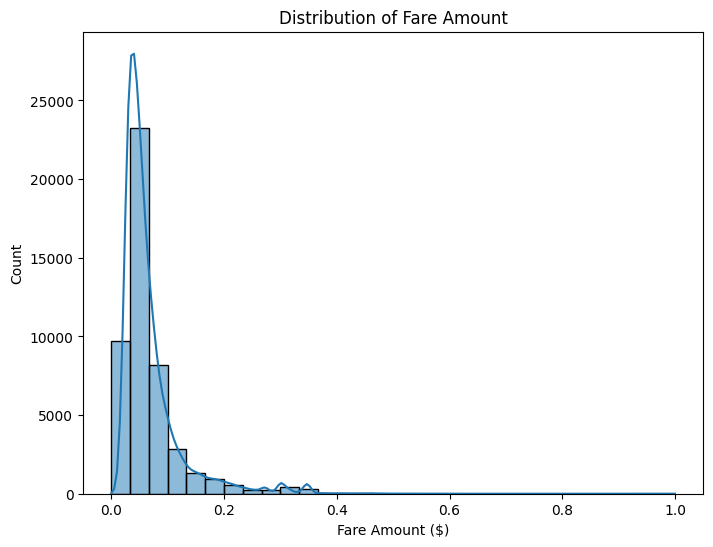

In [ ]:
plt.figure(figsize=(8, 6))
sns.histplot(data['fare_amount'], bins=30, kde=True)
plt.title("Distribution of Fare Amount")
plt.xlabel("Fare Amount ($)")
plt.show()

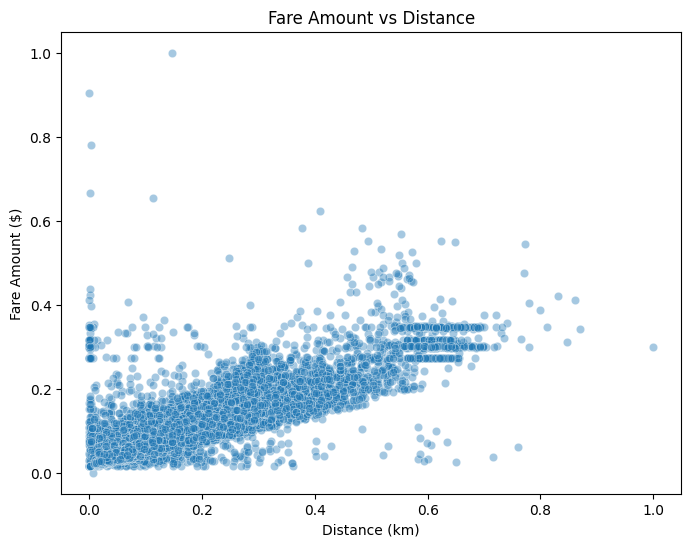

In [ ]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=data['haversine_distance_km'], y=data['fare_amount'], alpha=0.4)
plt.title("Fare Amount vs Distance")
plt.xlabel("Distance (km)")
plt.ylabel("Fare Amount ($)")
plt.show()

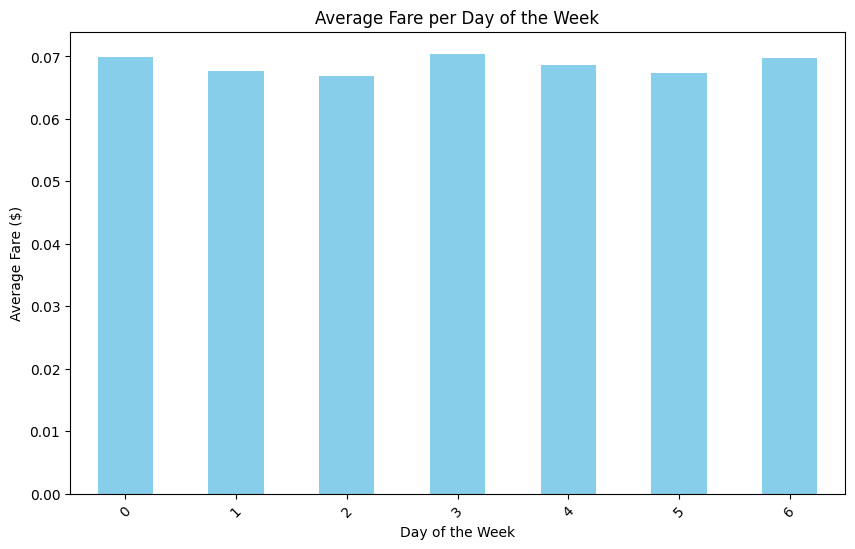

In [ ]:
avg_fare_per_day = data.groupby('pickup_weekday')['fare_amount'].mean()

plt.figure(figsize=(10, 6))
avg_fare_per_day.plot(kind='bar', color='skyblue')
plt.title("Average Fare per Day of the Week")
plt.ylabel("Average Fare ($)")
plt.xlabel("Day of the Week")
plt.xticks(rotation=45)
plt.show()

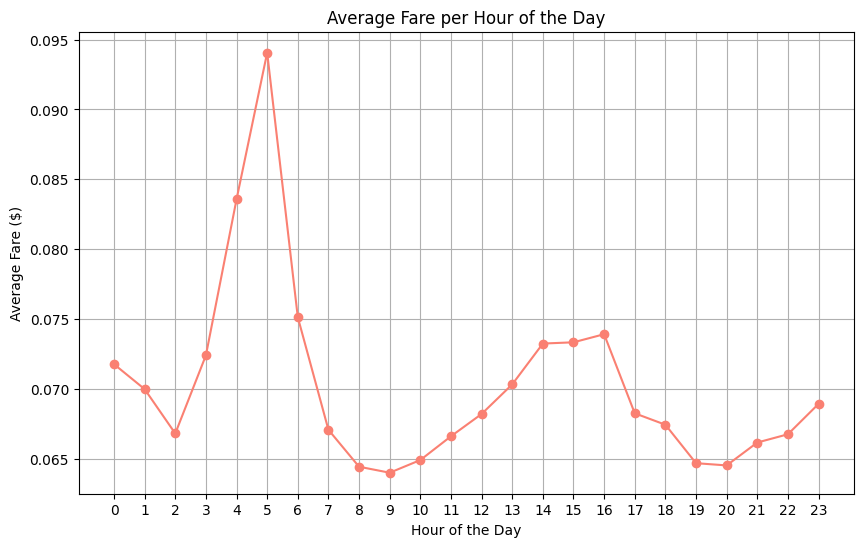

In [ ]:
avg_fare_per_hour = data.groupby('pickup_hour')['fare_amount'].mean()

plt.figure(figsize=(10, 6))
avg_fare_per_hour.plot(kind='line', marker='o', color='salmon')
plt.title("Average Fare per Hour of the Day")
plt.ylabel("Average Fare ($)")
plt.xlabel("Hour of the Day")
plt.xticks(range(24))
plt.grid(True)
plt.show()

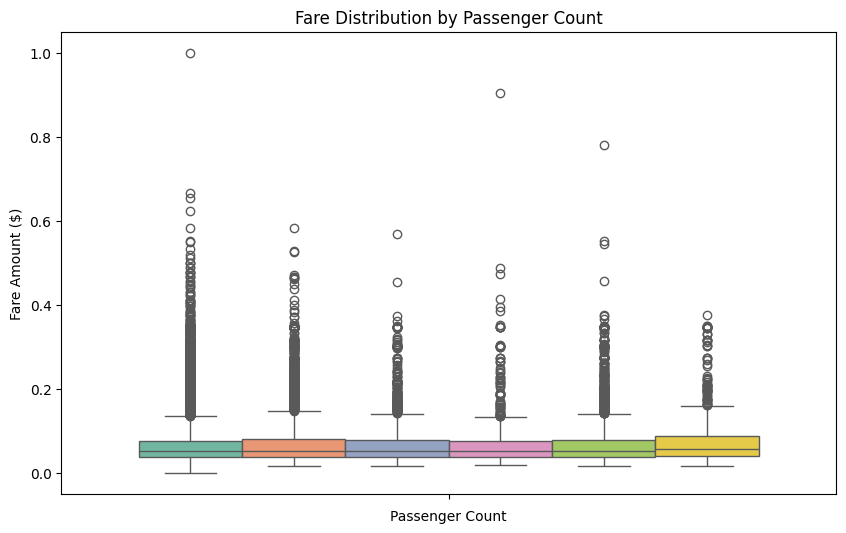

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(hue='passenger_count', y='fare_amount', data=data, palette='Set2', legend=False)
plt.title("Fare Distribution by Passenger Count")
plt.xlabel("Passenger Count")
plt.ylabel("Fare Amount ($)")
plt.show()


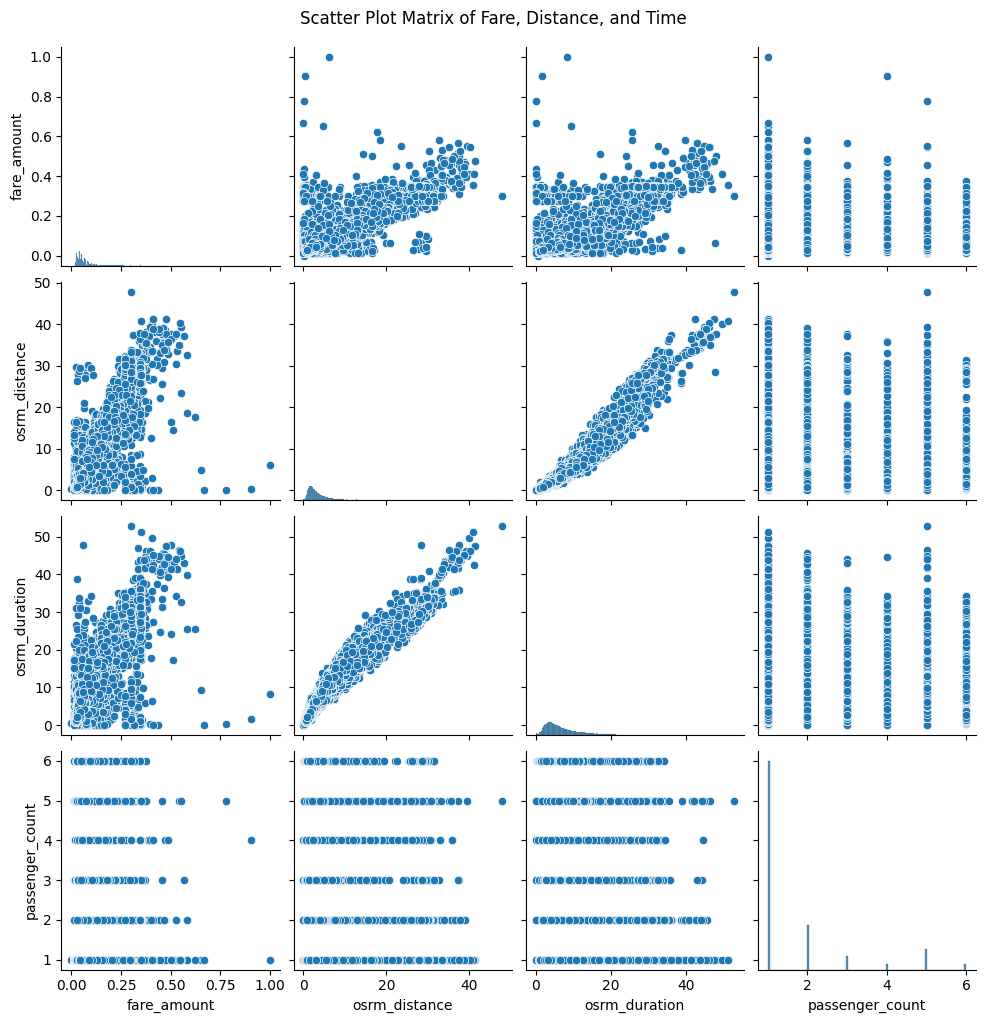

In [ ]:
data_subset = data[['fare_amount', 'osrm_distance', 'osrm_duration', 'passenger_count']]

sns.pairplot(data_subset, kind='scatter', markers='o')
plt.suptitle("Scatter Plot Matrix of Fare, Distance, and Time", y=1.02)
plt.show()

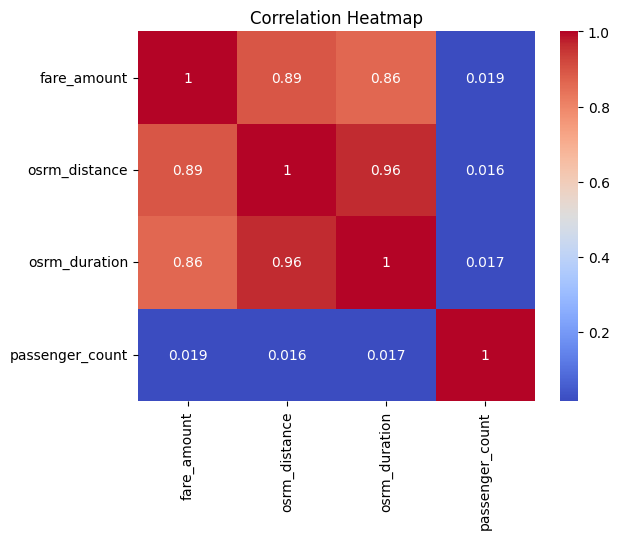

In [ ]:
sns.heatmap(data_subset.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

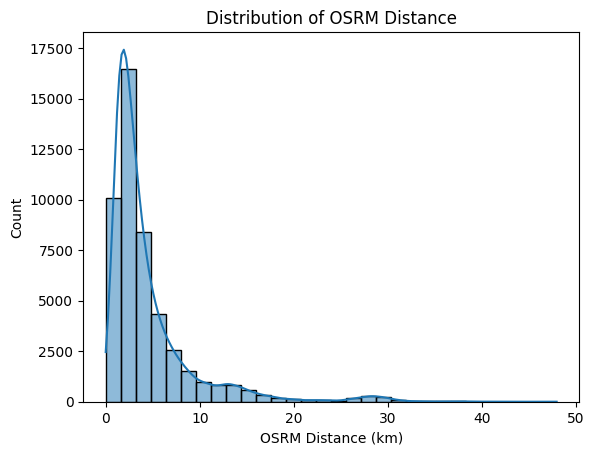

In [ ]:
sns.histplot(data['osrm_distance'], bins=30, kde=True)
plt.title("Distribution of OSRM Distance")
plt.xlabel("OSRM Distance (km)")
plt.show()

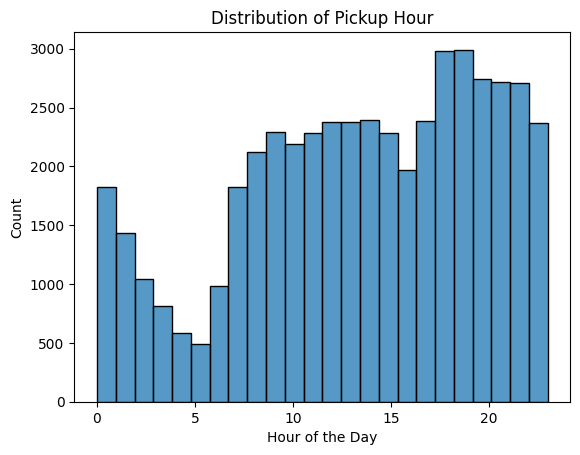

In [ ]:
sns.histplot(data['pickup_hour'], bins=24)
plt.title("Distribution of Pickup Hour")    
plt.xlabel("Hour of the Day")
plt.show()

In [ ]:
data.columns

Index(['fare_amount', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count',
       'pickup_hour', 'pickup_weekday', 'pickup_month',
       'haversine_distance_km', 'is_night', 'is_late_night', 'is_weekend',
       'lat_diff', 'lon_diff', 'osrm_distance', 'osrm_duration',
       'near_hotspot'],
      dtype='object')

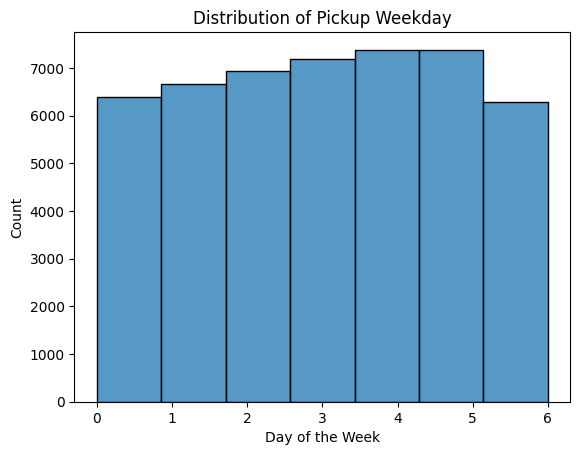

In [ ]:
sns.histplot(data['pickup_weekday'], bins=7)
plt.title("Distribution of Pickup Weekday")
plt.xlabel("Day of the Week")
plt.show()

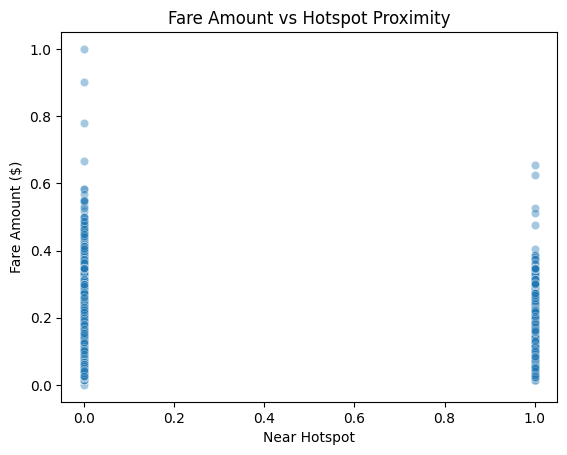

In [ ]:
sns.scatterplot(x=data['near_hotspot'], y=data['fare_amount'], alpha=0.4)
plt.title("Fare Amount vs Hotspot Proximity")
plt.xlabel("Near Hotspot")
plt.ylabel("Fare Amount ($)")
plt.show()

In [ ]:
map_nyc = folium.Map(location=[40.7128, -74.0060], zoom_start=12)

pickup_locations = data[['pickup_latitude', 'pickup_longitude', 'fare_amount']] 

locations = pickup_locations[['pickup_latitude', 'pickup_longitude', 'fare_amount']].values.tolist()

HeatMap(locations).add_to(map_nyc)

map_nyc.save("nyc_fare_heatmap.html")

map_nyc

<Axes: xlabel='osrm_distance', ylabel='osrm_duration'>

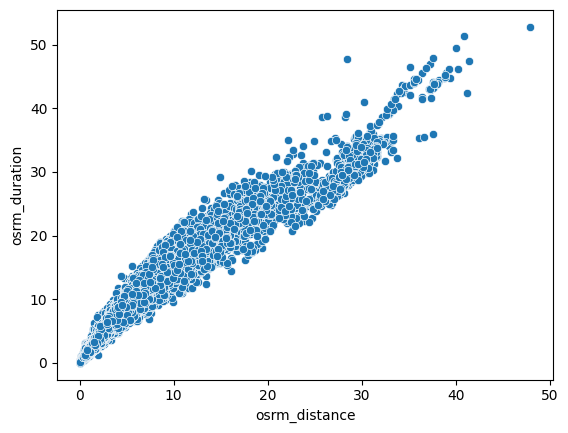

In [ ]:
sns.scatterplot(x=data['osrm_distance'],y=data['osrm_duration'])

<Axes: xlabel='fare_amount', ylabel='osrm_duration'>

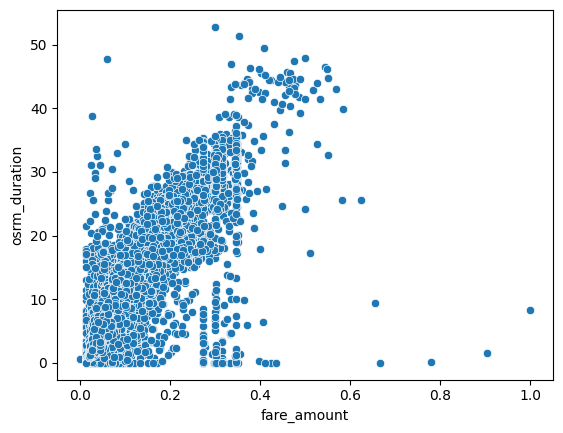

In [ ]:
sns.scatterplot(x=data['fare_amount'],y=data['osrm_duration'])

In [ ]:
data.columns

Index(['fare_amount', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count',
       'pickup_hour', 'pickup_weekday', 'pickup_month',
       'haversine_distance_km', 'is_night', 'is_late_night', 'is_weekend',
       'lat_diff', 'lon_diff', 'osrm_distance', 'osrm_duration',
       'near_hotspot'],
      dtype='object')

In [ ]:
X = data[[
    'osrm_distance',       
    'osrm_duration',       
    'pickup_hour',         
    'pickup_weekday',
    'pickup_month',
    'is_night',            
    'is_late_night',       
    'is_weekend',          
    'near_hotspot',             
]]
y = data['fare_amount']  

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

print(f"Training set: {X_train.shape}, Testing set: {X_test.shape}")

Training set: (33731, 9), Testing set: (14457, 9)


In [ ]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

lr_predictions = lr_model.predict(X_test)

print("Linear Regression Performance:")
print(f"MAE: {mean_absolute_error(y_test, lr_predictions):.4f}")
print(f"RMSE: {root_mean_squared_error(y_test, lr_predictions):.4f}")
print(f"R²: {r2_score(y_test, lr_predictions):.4f}")

Linear Regression Performance:
MAE: 0.0129
RMSE: 0.0234
R²: 0.8299


In [ ]:
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
xgb_model.fit(X_train, y_train)

xgb_predictions = xgb_model.predict(X_test)

print("\nXGBoost Performance:")
print(f"MAE: {mean_absolute_error(y_test, xgb_predictions):.4f}")
print(f"RMSE: {root_mean_squared_error(y_test, xgb_predictions):.4f}")
print(f"R²: {r2_score(y_test, xgb_predictions):.4f}")


XGBoost Performance:
MAE: 0.0125
RMSE: 0.0232
R²: 0.8337


In [ ]:
poly = PolynomialFeatures(degree=2)

X_train_poly2 = poly.fit_transform(X_train)
X_test_poly2 = poly.transform(X_test)

poly_model_2 = LinearRegression()
poly_model_2.fit(X_train_poly2, y_train)

poly_model_2_predictions = poly_model_2.predict(X_test_poly2)

print("2nd Degree Polynomial Regression Performance:")
print(f"MAE: {mean_absolute_error(y_test, poly_model_2_predictions):.4f}")
print(f"RMSE: {root_mean_squared_error(y_test, poly_model_2_predictions):.4f}")
print(f"R²: {r2_score(y_test, poly_model_2_predictions):.4f}")

2nd Degree Polynomial Regression Performance:
MAE: 0.0128
RMSE: 0.0232
R²: 0.8334


In [ ]:
poly3 = PolynomialFeatures(degree=3)

X_train_poly3 = poly3.fit_transform(X_train)
X_test_poly3 = poly3.transform(X_test)

poly_model_3 = LinearRegression()
poly_model_3.fit(X_train_poly3, y_train)

poly_model_3_predictions = poly_model_3.predict(X_test_poly3)

print("3rd Degree Polynomial Regression Performance:")
print(f"MAE: {mean_absolute_error(y_test, poly_model_3_predictions):.4f}")
print(f"RMSE: {root_mean_squared_error(y_test, poly_model_3_predictions):.4f}")
print(f"R²: {r2_score(y_test, poly_model_3_predictions):.4f}")

3rd Degree Polynomial Regression Performance:
MAE: 0.0128
RMSE: 0.0231
R²: 0.8354


In [ ]:
lgb_model = lgb.LGBMRegressor(n_estimators=100, learning_rate=0.1, max_depth=10,force_row_wise=True)
lgb_model.fit(X_train, y_train)

lgb_predictions = lgb_model.predict(X_test)

print("\nLightGBM Performance:")
print(f"MAE: {mean_absolute_error(y_test, lgb_predictions):.4f}")
print(f"RMSE: {root_mean_squared_error(y_test, lgb_predictions):.4f}")
print(f"R²: {r2_score(y_test, lgb_predictions):.4f}")

[LightGBM] [Info] Total Bins 562
[LightGBM] [Info] Number of data points in the train set: 33731, number of used features: 9
[LightGBM] [Info] Start training from score 0.068340

LightGBM Performance:
MAE: 0.0125
RMSE: 0.0228
R²: 0.8393


In [ ]:
print("Model Comparison(Cross Validation Score):")
for i,j,k in zip([lr_model, poly_model_2, poly_model_3, xgb_model, lgb_model], 
                                     [X_train, X_train_poly2, X_train_poly3, X_train, X_train], 
                                     ['Linear Regression', '2nd Order Polynomial Regression', '3rd Order Polynomial Regression', 'XGBoost', 'LightGBM']):
    sc = make_scorer(root_mean_squared_error)
    rmse_scores = cross_val_score(i, j, y_train, cv=5, scoring=sc)
    rmse_validation_score = rmse_scores.mean()
    print(f"{k} -> Cross Validation Score(RMSE): {rmse_validation_score:.5f}")


Model Comparison(Cross Validation Score):
Linear Regression -> Cross Validation Score(RMSE): 0.02595
2nd Order Polynomial Regression -> Cross Validation Score(RMSE): 0.02574
3rd Order Polynomial Regression -> Cross Validation Score(RMSE): 0.02560
XGBoost -> Cross Validation Score(RMSE): 0.02533
[LightGBM] [Info] Total Bins 562
[LightGBM] [Info] Number of data points in the train set: 26984, number of used features: 9
[LightGBM] [Info] Start training from score 0.068130
[LightGBM] [Info] Total Bins 562
[LightGBM] [Info] Number of data points in the train set: 26985, number of used features: 9
[LightGBM] [Info] Start training from score 0.068572
[LightGBM] [Info] Total Bins 562
[LightGBM] [Info] Number of data points in the train set: 26985, number of used features: 9
[LightGBM] [Info] Start training from score 0.068377
[LightGBM] [Info] Total Bins 562
[LightGBM] [Info] Number of data points in the train set: 26985, number of used features: 9
[LightGBM] [Info] Start training from score 0

In [ ]:
print("Model Comparison:")
for i,j in zip([lr_predictions, poly_model_2_predictions, poly_model_3_predictions, xgb_predictions, lgb_predictions], ['Linear Regression','2nd Order Polynomial Regression', '3rd Order Polynomial Regression','XGBoost','LightGBM']):
    print(f"{j} -> MAE: {mean_absolute_error(y_test, i):.5f}, "
    f"RMSE: {root_mean_squared_error(y_test, i):.5f}, "
    f"R²: {r2_score(y_test, i):.5f}")

Model Comparison:
Linear Regression -> MAE: 0.01287, RMSE: 0.02345, R²: 0.82992
2nd Order Polynomial Regression -> MAE: 0.01278, RMSE: 0.02321, R²: 0.83339
3rd Order Polynomial Regression -> MAE: 0.01279, RMSE: 0.02307, R²: 0.83540
XGBoost -> MAE: 0.01253, RMSE: 0.02318, R²: 0.83374
LightGBM -> MAE: 0.01252, RMSE: 0.02279, R²: 0.83931


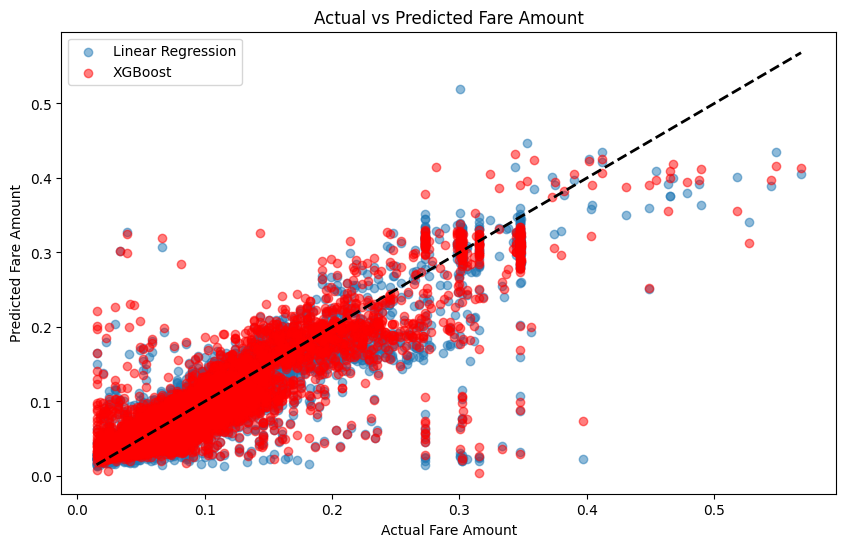

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, lr_predictions, alpha=0.5, label="Linear Regression")
plt.scatter(y_test, xgb_predictions, alpha=0.5, label="XGBoost", color="red")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel("Actual Fare Amount")
plt.ylabel("Predicted Fare Amount")
plt.title("Actual vs Predicted Fare Amount")
plt.legend()
plt.show()

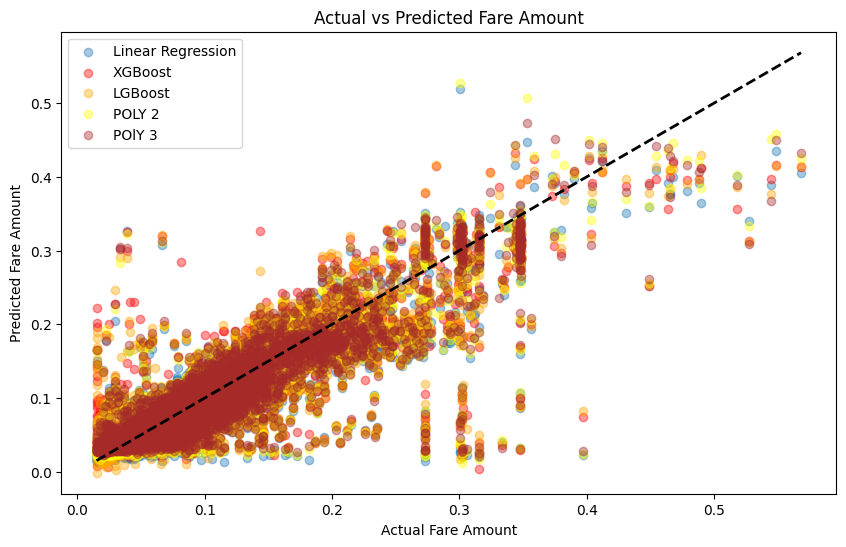

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, lr_predictions, alpha=0.4, label="Linear Regression")
plt.scatter(y_test, xgb_predictions, alpha=0.4, label="XGBoost", color="red")
plt.scatter(y_test, lgb_predictions, alpha=0.4, label="LGBoost", color="orange")
plt.scatter(y_test, poly_model_2_predictions, alpha=0.4, label="POLY 2", color="yellow")
plt.scatter(y_test, poly_model_3_predictions, alpha=0.4, label="POlY 3", color="brown")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel("Actual Fare Amount")
plt.ylabel("Predicted Fare Amount")
plt.title("Actual vs Predicted Fare Amount")
plt.legend()
plt.show()

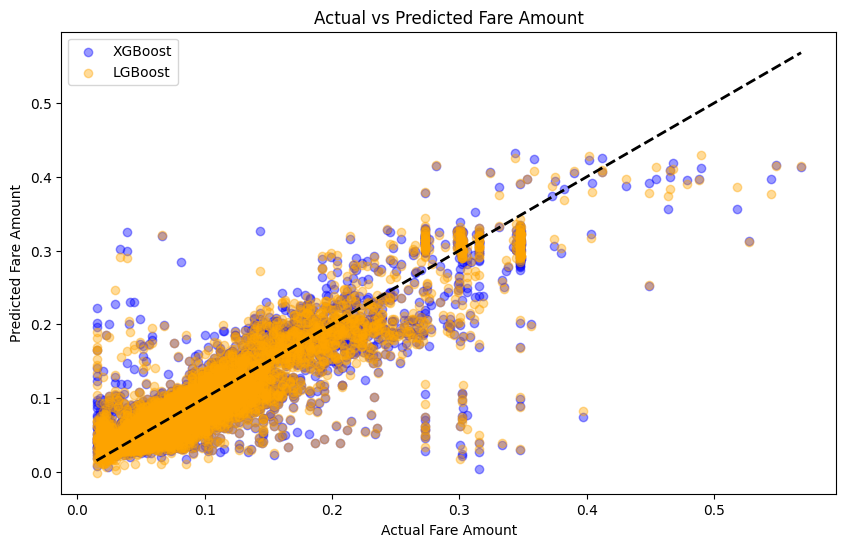

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, xgb_predictions, alpha=0.4, label="XGBoost", color="blue")
plt.scatter(y_test, lgb_predictions, alpha=0.4, label="LGBoost", color="orange")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel("Actual Fare Amount")
plt.ylabel("Predicted Fare Amount")
plt.title("Actual vs Predicted Fare Amount")
plt.legend()
plt.show()